In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [4]:
data_batch1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch4 = unpickle('cifar-10-batches-py/data_batch_4')
data_batch5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')

input_batch1 = data_batch1['data']
input_batch2 = data_batch2['data']
input_batch3 = data_batch3['data']
input_batch4 = data_batch4['data']
input_batch5 = data_batch5['data']
test_input = test_batch['data']

label_batch1 = np.array(data_batch1['labels'])
label_batch2 = np.array(data_batch2['labels'])
label_batch3 = np.array(data_batch3['labels'])
label_batch4 = np.array(data_batch4['labels'])
label_batch5 = np.array(data_batch5['labels'])
test_label = np.array(test_batch['labels'])

In [5]:
input_data = np.vstack((input_batch1, input_batch2, input_batch3, input_batch4, input_batch5))
labels = np.hstack((label_batch1, label_batch2, label_batch3, label_batch4, label_batch5))
labels

array([6, 9, 9, ..., 9, 1, 1])

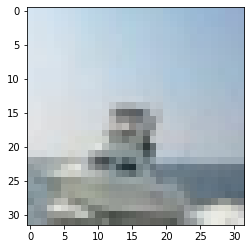

In [6]:
input_data = np.reshape(input_data, (50000,3,32,32)).transpose(0,2,3,1)/255
test_data = np.reshape(test_input, (10000,3,32,32)).transpose(0,2,3,1)/255
label = np.eye(10)[labels]
test_label = np.eye(10)[test_label]
plt.imshow(input_data[100])

In [7]:
def init_weights(shape):
    W = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(W)

In [8]:
def init_bias(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)

In [9]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

In [10]:
def max_pool2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2,2, 1], strides=[1,2,2,1], padding='SAME')

In [11]:
def convolution_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [12]:
def dense_layer(input_layer, size):
    W = init_weights([int(input_layer.get_shape()[1]), size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [13]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [14]:
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [15]:
conv1 = convolution_layer(x, [4,4,3,32])
max_pool_conv1 = max_pool2by2(conv1)

In [16]:
max_pool_conv1

<tf.Tensor 'MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>

In [17]:
conv2 = convolution_layer(max_pool_conv1, [4,4,32,64])
max_pool_conv2 = max_pool2by2(conv2)

In [18]:
max_pool_conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 8, 64) dtype=float32>

In [19]:
dense_input_flat = tf.reshape(max_pool_conv2, [-1, 8*8*64])

In [20]:
dense1 = tf.nn.relu(dense_layer(dense_input_flat, 1024))

In [21]:
drop_out_prob = tf.placeholder(tf.float32)

drop_out_layer = tf.nn.dropout(dense1, keep_prob=drop_out_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
y_pred = dense_layer(drop_out_layer, 10)

In [23]:
loss_func = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(loss_func)

In [25]:
init = tf.global_variables_initializer()

In [26]:
i = 0

In [27]:
def load_batch(X, y, batch_size):
    global i
    if i >= len(X):
        i = 0
    batch_x = X[i:i+batch_size]
    batch_y = y[i:i+batch_size]
    i += batch_size
    return batch_x, batch_y

In [28]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(5000):
        
        batch_x, batch_y = load_batch(input_data, label, 100)
        
        sess.run(train, feed_dict={x:batch_x, y_true:batch_y, drop_out_prob:0.5})
        
        
    matches = tf.equal(tf.arg_max(y_pred,1), tf.arg_max(y_true, 1))

    acc = tf.reduce_mean(tf.cast(matches, tf.float32))
    print('training acc: ', sess.run(acc, feed_dict={x:input_data, y_true:label, drop_out_prob:1.0}))
    print('validation acc: ', sess.run(acc, feed_dict={x:test_data, y_true:test_label, drop_out_prob:1.0}))

training acc:  0.90324
validation acc:  0.699
